In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from jupyterthemes import jtplot
from sklearn.model_selection import train_test_split
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

c:\users\sudhk\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# !pip install wordcloud
# !pip install jupyterthemes

In [3]:
# Load the dataset
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

In [4]:
true_df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
21412  BRUSSELS (Reuters) - NATO allies on Tuesday we...     worldnews   
21413  LONDON (Reuters) - LexisNexis, a provider of l...     worldnews   
21414  MINSK (Reuters) - In the shadow of disused Sov...     worldnews   
21415  MOSCOW (Reuters) - Vatican Secretary of State ...     worldnews   
21416  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...     worldnews   

                     date  
0      December 31, 2017   
1      December 29, 2017   
2      December 31, 2017   
3      December 30, 2017   
4      December 29, 2017   
...                   ...  
21412    August 22, 2017   
21413    August 22, 2017   
21414    August 22, 2017   
21415    August 22, 2017   
21416    August 22, 2017   

[21417 rows x 4 columns]

In [5]:
fake_df

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
0      Donald Trump just couldn t wish all Americans ...         News   
1      House Intelligence Committee Chairman Devin Nu...         News   
2      On Friday, it was revealed that former Milwauk...         News   
3      On Christmas day, Donald Trump announced that ...         News   
4      Pope Francis used his annual Christmas Day mes...         News   
...                                                  ...          ...   
23476  21st Century Wire says As 21WIRE reported earl...  Middle-east   
23477  21st Century Wire says It s a familiar theme. ...  Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...  Middle-east   
23479  21st Century Wire says Al Jazeera America will...  Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...  Middle-east   

                    date  
0      December 31, 2017  
1      December 31, 2017  
2      December 30, 2017  
3      December 29, 2017  
4      December 25, 2017  
...                  ...  
23476   January 16, 2016  
23477   January 16, 2016  
23478   January 15, 2016  
23479   January 14, 2016  
23480   January 12, 2016  

[23481 rows x 4 columns]

In [6]:
# To check the null values in the dataset

In [7]:
true_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [8]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [9]:
# Concatingating the dataset
true_df['isfake'] = 0
fake_df['isfake'] = 1


In [10]:
comp_df = pd.concat([true_df, fake_df]).reset_index(drop=True)
comp_df = comp_df.drop('date', axis=1)

In [11]:
comp_df['complete_text'] = comp_df['title'] + " " + comp_df['text']
comp_df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isfake                                      complete_text  
0           0  As U.S. budget fight looms, Republicans flip t...  
1           0  U.S. military to accept transgender recruits o...  
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...  
3           0  FBI Russia probe helped by Australian diplomat...  
4           0  Trump wants Postal Service to charge 'much mor...  
...       ...                                                ...  
44893       1  McPain: John McCain Furious That Iran Treated ...  
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  
44896       1  How to Blow $700 Million: Al Jazeera America F...  
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...  

[44898 rows x 5 columns]

In [12]:
# Cleaning the data:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
def cleaning(text):
    cleaned = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            cleaned.append(token)
    return cleaned

In [14]:
comp_df['clean'] = comp_df['complete_text'].apply(cleaning)

In [15]:
# list of words:
list_of_words = []
for text in comp_df.clean:
    for word in text:
        list_of_words.append(word)

In [16]:
vocab = list(set(list_of_words))
len_vocab = len(vocab)
len_vocab

108704

In [17]:
len(list_of_words)

9276947

In [18]:
comp_df['clean_description'] = comp_df['clean'].apply(lambda x: " ".join(x))

In [19]:
comp_df = comp_df[['subject', 'isfake', 'clean_description']]

In [20]:
comp_df

subject  isfake                                  clean_description
0      politicsNews       0  budget fight looms republicans flip fiscal scr...
1      politicsNews       0  military accept transgender recruits monday pe...
2      politicsNews       0  senior republican senator mueller washington r...
3      politicsNews       0  russia probe helped australian diplomat washin...
4      politicsNews       0  trump wants postal service charge amazon shipm...
...             ...     ...                                                ...
44893   Middle-east       1  mcpain john mccain furious iran treated sailor...
44894   Middle-east       1  justice yahoo settles mail privacy class actio...
44895   Middle-east       1  sunnistan allied safe zone plan territorial bo...
44896   Middle-east       1  blow million jazeera america finally calls qui...
44897   Middle-east       1  navy sailors held iranian military signs neoco...

[44898 rows x 3 columns]

In [21]:
# Visualizing the data to find insights

<AxesSubplot:xlabel='count', ylabel='subject'>

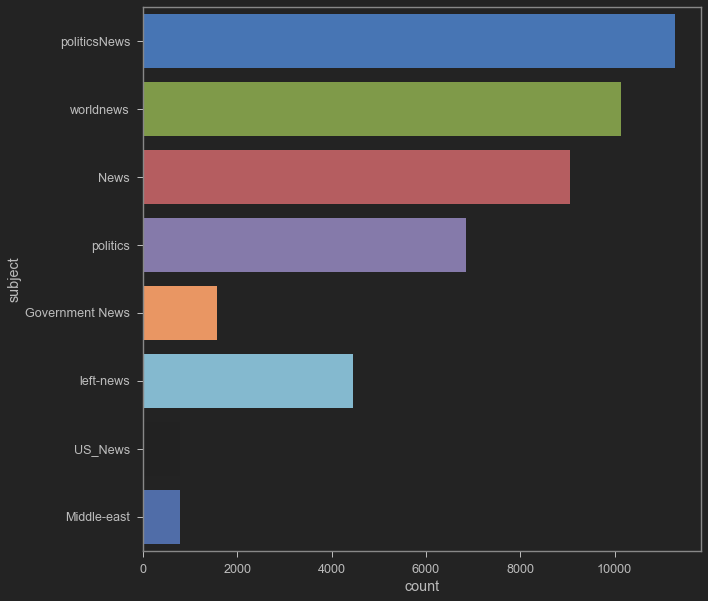

In [22]:
plt.figure(figsize=(10,10))
sns.countplot(y='subject', data=comp_df)

<AxesSubplot:xlabel='count', ylabel='isfake'>

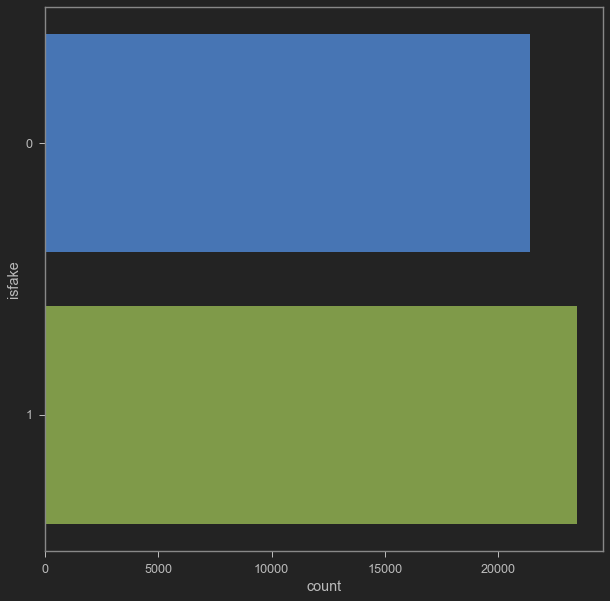

In [23]:
plt.figure(figsize=(10,10))
sns.countplot(y='isfake', data=comp_df)
# 0-> Fake and 1-> True

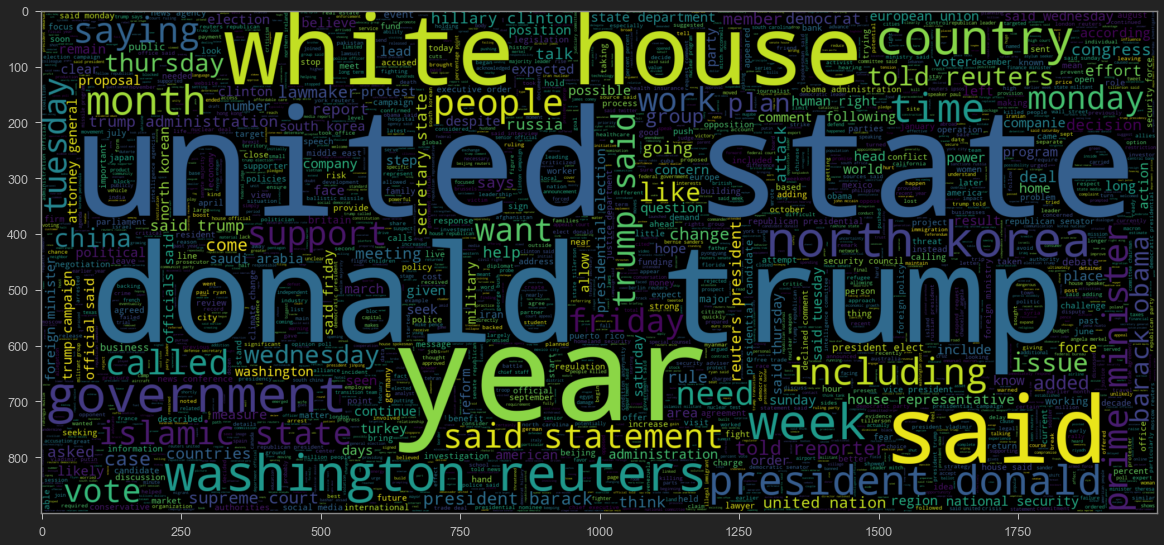

In [24]:
# Words in True news 

plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2500, width=2000, height=900, stopwords=stop_words).generate(' '.join(comp_df[comp_df.isfake == 0].clean_description))
plt.imshow(wc, interpolation = 'bilinear')

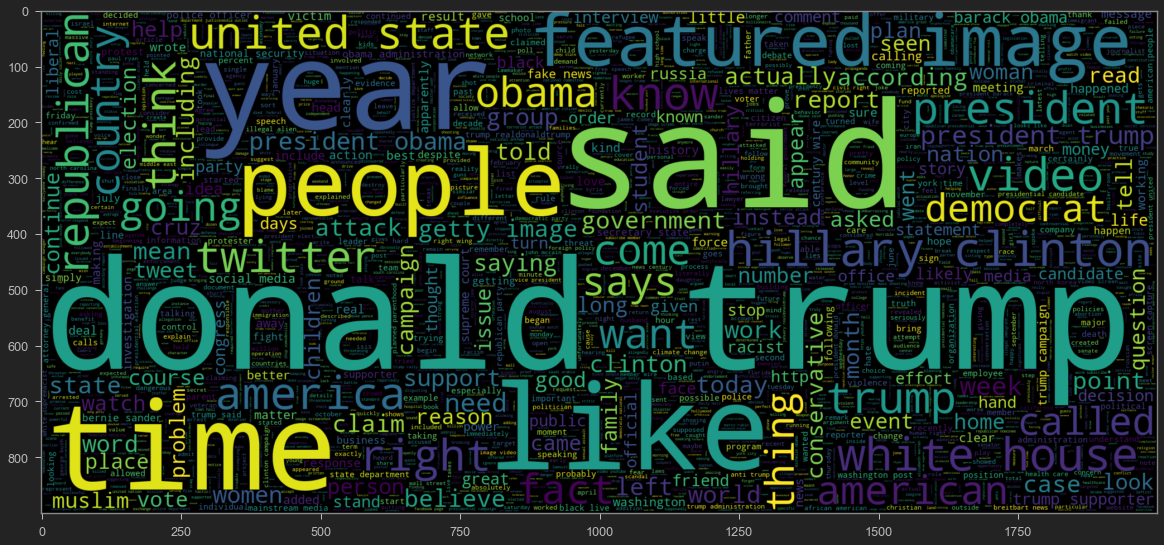

In [25]:
# Words in Fake news 

plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2500, width=2000, height=900, stopwords=stop_words).generate(' '.join(comp_df[comp_df.isfake == 1].clean_description))
plt.imshow(wc, interpolation = 'bilinear')

In [26]:
# Length of the documents:
maxlen = -1
for text in comp_df.clean_description:
    tokens = nltk.word_tokenize(text)
    if (maxlen < len(tokens)):
        maxlen = len(tokens)
print('The maximum number of words in the desctiption: ', maxlen)

The maximum number of words in the desctiption:  4405


In [27]:
# visualize the distribution of number of words in a text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in comp_df.clean_description], nbins = 100)
fig.show()

In [28]:
# Splitting data:
x_train, x_test, y_train, y_test = train_test_split(comp_df.clean_description, comp_df.isfake, test_size=0.2)

In [29]:
# Creating the tokenized sequence:
tokenizer = Tokenizer(num_words= len_vocab)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [30]:
# Adding padding 
padding_train = pad_sequences(train_sequences, maxlen=maxlen, padding='post', truncating='post')
padding_test = pad_sequences(test_sequences, maxlen=maxlen, padding='post', truncating='post')

In [33]:
# Designing the model:
model = Sequential()
model.add(Embedding(len_vocab, output_dim=32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          3478528   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 3,496,225
Trainable params: 3,496,225
Non-trainable params: 0
_________________________________________________________________


In [34]:
y_train = np.asarray(y_train)

In [35]:
# train the model
model.fit(padding_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2, verbose = 1)

Epoch 1/2
506/506 [==============================] - 6334s 13s/step - loss: 0.1235 - acc: 0.9500 - val_loss: 0.0098 - val_acc: 0.9972
Epoch 2/2
506/506 [==============================] - 5044s 10s/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0101 - val_acc: 0.9978


In [42]:
pred =  model.predict(padding_test)

In [43]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [44]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9992204899777283


<AxesSubplot:>

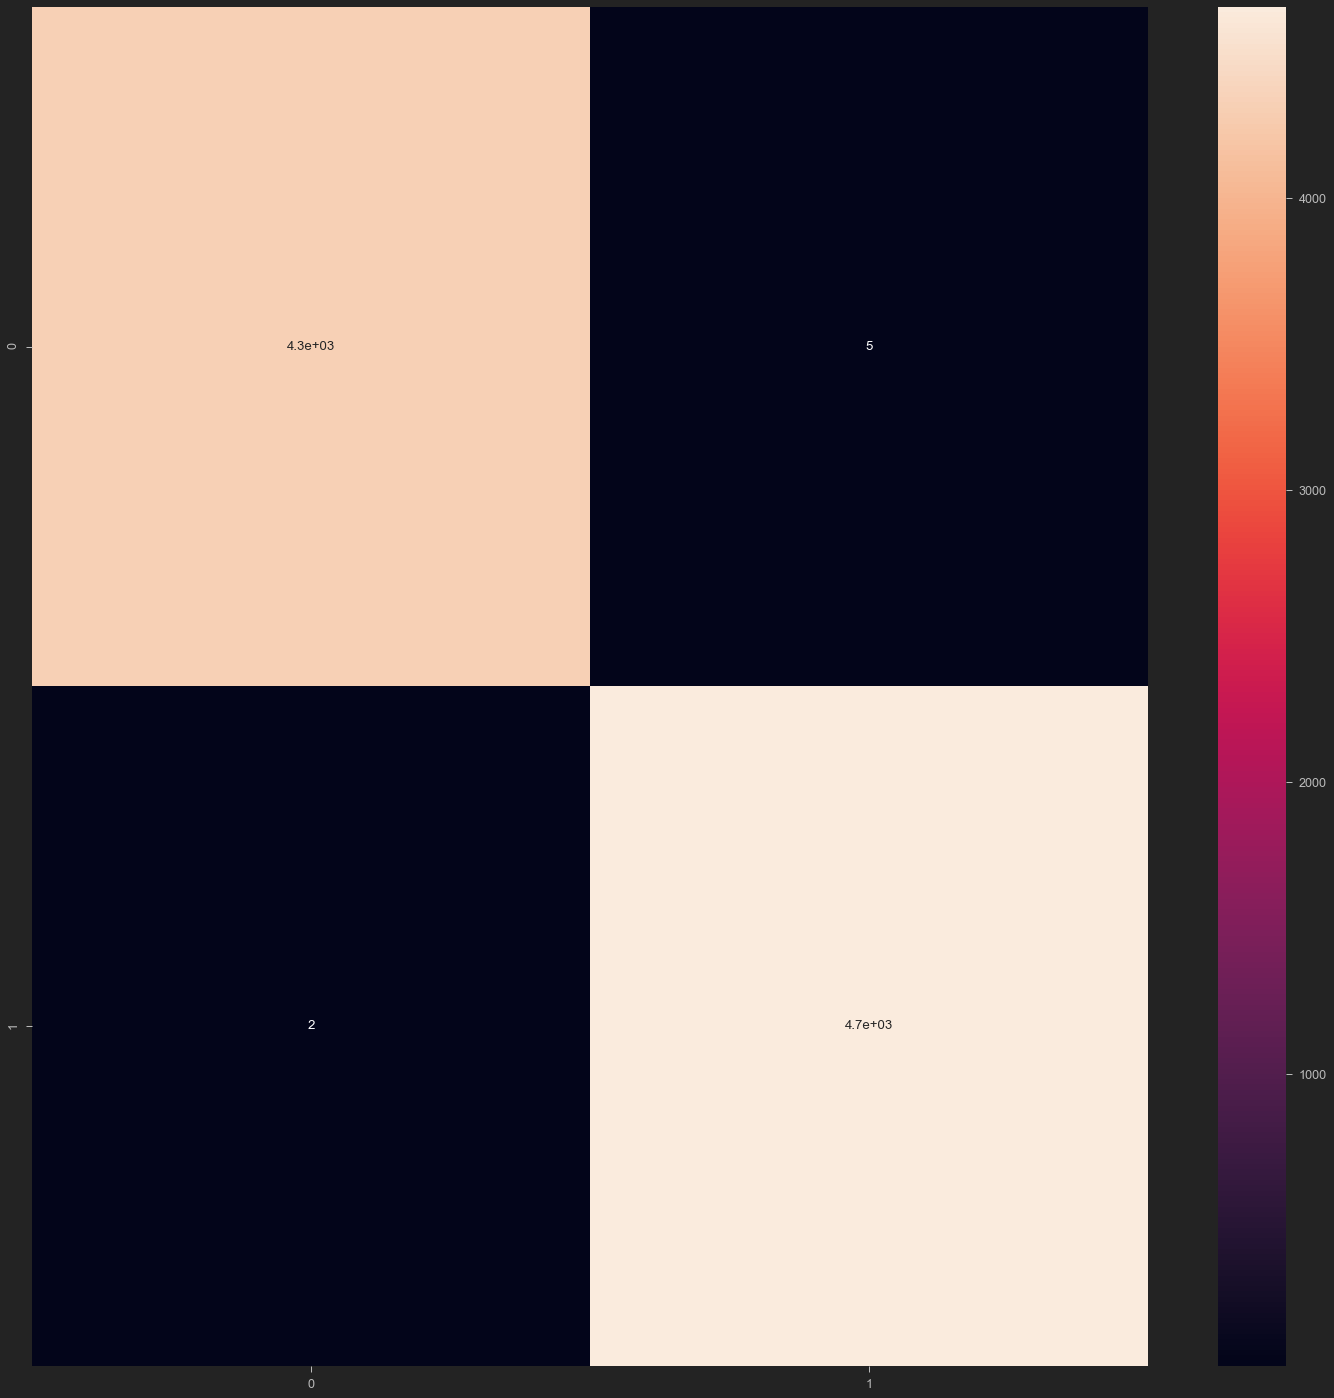

In [52]:
# get the confusion matrix
# 0 -> True, 1 -> Fake

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)